In [86]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

PWD = Path.cwd()

In [87]:
df = pd.read_csv(
    f'{PWD}/LLM+Planning+Evaluation_7+October+2024_14.50.tsv',
    sep='\t',
    encoding='utf-16',
)

questions = pd.read_json('../surveys/final.jsonl', lines=True)

datasets = questions['dataset'].unique()[:-1]
models = questions['model'].unique()
dataset_model_combinations = [(d, m) for d in datasets for m in models]

POINT_SCALE = 5


def t2i(
    text: str,
    point_scale: int = 5,
) -> int:
    if point_scale == 5:
        mapping = {
            'Strongly disagree': 1,
            'Somewhat disagree': 2,
            'Neither agree nor disagree': 3,
            'Somewhat agree': 4,
            'Strongly agree': 5,
        }
    elif point_scale == 3:
        mapping = {
            'Strongly disagree': 1,
            'Somewhat disagree': 1,
            'Neither agree nor disagree': 2,
            'Somewhat agree': 3,
            'Strongly agree': 3,
        }

    return mapping.get(text, None)


def i2t(
    integer: int,
    point_scale: int = 5,
) -> str:
    if point_scale == 5:
        mapping = {
            1: 'SD',
            2: 'sD',
            3: 'N',
            4: 'sA',
            5: 'SA',
        }
    elif point_scale == 3:
        mapping = {
            1: 'SD',
            2: 'N',
            3: 'SA',
        }

    return mapping.get(integer, None)

In [88]:
datasets, models

(array(['Franklin', 'GSM8k', 'HotpotQA'], dtype=object),
 array(['google/gemma-2-9b-it', 'meta-llama/Meta-Llama-3.1-8B-Instruct',
        'microsoft/Phi-3.5-mini-instruct', 'openai/gpt-4o-mini'],
       dtype=object))

In [89]:
questions.head()

,uuid,is_attention_check,dataset,model,question,parsed_response,html
0,36b1a3da-bc2b-4a9f-b0b5-31887af03c91,False,Franklin,google/gemma-2-9b-it,Which country will have the lower energy consu...,## Step-by-Step Plan:\n\n1. **Identify Data So...,<p><em>Which country will have the lower energ...
1,424e96e0-5051-426d-9d57-0ccc5fa352db,False,Franklin,google/gemma-2-9b-it,Which country in Northern Europe had the highe...,Here is the plan:\n\n1. **Define Northern Euro...,<p><em>Which country in Northern Europe had th...
2,c4b1e32f-1886-440a-9f9f-66a4d71eabdb,False,Franklin,google/gemma-2-9b-it,Which country in Eastern Asia had the highest ...,"## Plan:\n\n1. **Define ""Eastern Asia"":** Cons...",<p><em>Which country in Eastern Asia had the h...
3,b8d5fa16-e8fa-459c-93f7-3edc6b82b152,False,Franklin,google/gemma-2-9b-it,For the country in Micronesia that had the low...,## Plan:\n\n1. **Identify the country in Micro...,<p><em>For the country in Micronesia that had ...
4,5d5b6078-7e8e-4511-862b-3f2ecbccf019,False,Franklin,google/gemma-2-9b-it,Which country will have the higher life expect...,Here is the plan:\n\n1. **Identify reliable so...,<p><em>Which country will have the higher life...


In [90]:
# set column name to item in row 0
df.columns = df.iloc[0]
# drop the first row
original_columns = df.columns
df = df.drop(0)
# set index to 'PROLIFIC_PID'
df = df.set_index('PROLIFIC_PID')

In [91]:
# get durations and remove outliers
durations = df['Duration (in seconds)'].astype(float).map(lambda x: x / 60)
# print some stats about duration
print(durations.describe())

count    15.000000
mean     26.871111
std      13.335383
min      12.316667
25%      16.783333
50%      23.150000
75%      34.691667
max      57.000000
Name: Duration (in seconds), dtype: float64


In [92]:
# get durations which are more than 3 standard deviations lower than the mean
outliers_time = durations.mean() - 3 * durations.std()
print(f'Minimum permissible time: {outliers_time} minutes')
outliers = durations[durations < outliers_time]
print(outliers)
# remove outliers
df = df[~df.index.isin(outliers.index)]

Minimum permissible time: -13.135037821033709 minutes
Series([], Name: Duration (in seconds), dtype: float64)


In [93]:
# find the uuid in the string using regex to match a 36 character string
df.columns = df.columns.str.extract(r'([a-f0-9]{8}-[a-f0-9]{4}-[a-f0-9]{4}-[a-f0-9]{4}-[a-f0-9]{12}_[1-4])')[0]
# only return columns where there is a match
df = df[df.columns.dropna()]
# drop columns with all NaN values
df = df.dropna(axis=1, how='all')

In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15 entries, 5ebd30bca8d08203a6e2334f to 66a64ba586f60251fc451f9d
Columns: 272 entries, 36b1a3da-bc2b-4a9f-b0b5-31887af03c91_1 to 6ae2d51c-389b-42cf-8ea3-f4c0647f2096_4
dtypes: object(272)
memory usage: 32.5+ KB


In [95]:
attention_checks_uuid = 'd67998d7-8f14-4f50-823b-cb63027f21d9'
attention_check_cols = [col for col in df.columns if col.startswith(attention_checks_uuid)]
df = df.drop(attention_check_cols, axis=1)

attention_checks = [
    col
    for col in original_columns
    if col.startswith(attention_check_somewhat_agree_uuid) or col.startswith(attention_check_strongly_disagree_uuid)
]
# _4 - Where
# _3 - Could

In [96]:
attention_checks

["d67998d7-8f14-4f50-823b-cb63027f21d9_4 - Where is the Australian manufacturer of the Pontiac GTO headquartered?\n\nIdentify the Manufacturer: Research which company manufactured the Pontiac GTO in Australia.\n\n\nGather Background Information: Look into the history of the Pontiac GTO and its production, specifically focusing on the Australian context.\n\n\nLocate Headquarters Information: Search for the current headquarters location of the identified manufacturer.\n\n\nVerify the Information: Cross-check the headquarters information with reliable sources to ensure accuracy.\n\n\nCompile the Findings: Summarize the information gathered about the manufacturer and its headquarters location.\n\n\nCite Sources: Note down the sources used for the information to provide references if needed.\n\n\nI'm sorry, but I cannot perform the actions in the plan or provide the answer to the question. My capabilities are limited to outlining steps and providing guidance without executing the research o

Attention checks

In [97]:
# get the attention check uuids
attention_check_agree_uuid = 'd67998d7-8f14-4f50-823b-cb63027f21d9'
attention_check_disagree_uuid = 'd67998d7-8f14-4f50-823b-cb63027f21d9'
# get the attention check columns
attention_check_somewhat_agree = [f'{attention_check_agree_uuid}_{i}' for i in range(1, 5)]
attention_check_strongly_disagree = [f'{attention_check_disagree_uuid}_{i}' for i in range(1, 5)]
# make a dataframe with the attention check columns
attention_check_df = df[attention_check_somewhat_agree + attention_check_strongly_disagree]
# drop these columns from the dataframe
df = df.drop(attention_check_df.columns, axis=1)
# filter out the attention check columns
attention_check_df = attention_check_df.filter(regex='_4$', axis=1)
# rename the columns
attention_check_df = attention_check_df.rename(
    columns={
        'd67998d7-8f14-4f50-823b-cb63027f21d9_4': 'Somewhat agree',
        'e45763f5-53c4-4006-b2f8-edfbfd7e289e_4': 'Strongly disagree',
    }
)
# confirm columns contain the correct values
attention_check_df.head()

,Somewhat agree,Somewhat agree,Somewhat agree,Somewhat agree,Somewhat agree,Somewhat agree,Somewhat agree,Somewhat agree
PROLIFIC_PID,,,,,,,,
5ebd30bca8d08203a6e2334f,4,3,4,3,4,3,4,3
66f88d8c5fa10159db0db5c8,4,4,4,4,4,4,4,4
5f4cbdf9f599118d27c21442,4,4,4,4,4,4,4,4
669129db4e9424079e8fb66b,4,3,4,3,4,3,4,3
6648c2b185cc799f4856c1b4,4,2,4,2,4,2,4,2


In [98]:
# get rows where cell does not match column name for both columns
attention_check_df = attention_check_df[
    (attention_check_df['Somewhat agree'] != 'Somewhat agree')
    | (attention_check_df['Strongly disagree'] != 'Strongly disagree')
]
attention_check_df.loc['602a2911a73ba046955f6c58']

KeyError: 'Strongly disagree'

In [1062]:
print(f'Failed attention checks: {len(attention_check_df)}/{len(df)} ({len(attention_check_df) / len(df) * 100:.2f}%)')
# remove rows where attention check failed
df = df[~df.index.isin(attention_check_df.index)]

Failed attention checks: 30/267 (11.24%)


In [1063]:
pid = '6413a4a1a6e064ffb173f1ce'
print('Failed AC:', pid in attention_check_df.index)
print('In full df: ', pid in df.index)

Failed AC: False
In full df:  True


**Failed checks**

In [1064]:
print(*list(enumerate(sorted(attention_check_df.index.to_list()), 1)), sep='\n')

(1, '55884887fdf99b4020ba09bb')
(2, '55a7f195fdf99b7508d7d886')
(3, '56b4b565b2de2a000d3316ba')
(4, '585d139a460cb5000183f705')
(5, '58d8fcb9f94de20001fbcd0d')
(6, '59e7232f24d7bf00012f112e')
(7, '5b7d4bd487d85f0001ba8b6e')
(8, '5e863db644d87426bbe2e92a')
(9, '5e86c11942701c2ffda5d113')
(10, '5f11eb333c6e2c0df5b92270')
(11, '602a2911a73ba046955f6c58')
(12, '62db2644ab0a3a353c0dcb54')
(13, '6396044f6ae489bb820c67a5')
(14, '63d5daa80d80a745de740c13')
(15, '63fa6269a045cb36f1757a59')
(16, '65de5c8f7461ee4ad081dd65')
(17, '65f458465d662ccfda71310e')
(18, '660453c9877e571d12b555f7')
(19, '66548cf3c4c63418286fc428')
(20, '6655d895e8c33b7738009342')
(21, '6659c9abe870396b7be8ea34')
(22, '66704e9e669e722abcd02aa6')
(23, '66a25dc86f877fad5ce20223')
(24, '66ae46354f66a46055daf8f7')
(25, '66c4eb33c6ea3ce75318b5bc')
(26, '66d09cad71f1aa6d4835f142')
(27, '66d82bed7186e76bbd4e9f87')
(28, '66db7fdfdace7432da530fef')
(29, '66e04be8eee549c122da56b0')
(30, '66e83899e3110b97ab0bda09')


In [1065]:
# convert text to integer
point_scale = 5
df = df.map(lambda x: t2i(x, point_scale))

In [1066]:
# get rows where all non-NaN values are the same
rows = df.apply(lambda x: len(set(x.dropna())) == 1, axis=1)
# print rows where value is true and not false
rows = rows[rows == True]
print(f'Rows with same values: {len(rows)} ({len(rows) / len(df) * 100:.2f}%)')
# drop these rows from the dataframe
df = df.drop(rows.index)

Rows with same values: 0 (0.00%)


In [1067]:
"""
Split main dataframe into 3 dataframes for each variation of the question.
Split also by dataset and model.
"""
# get uuids in survey
uuids_in_survey = {i.split('_')[0] for i in df.columns}
# get questions where questions['uuid'] is in uuids_in_survey
questions = questions[questions['uuid'].isin(uuids_in_survey)]
# many-to-one mapping between ('model', 'dataset') and 'uuid'. get uuids for each ('model', 'dataset') pair
grouped_uuids = questions.groupby(['dataset', 'model'])['uuid'].apply(list).to_dict()
# each uuid contains 3 variations with suffixes _1, _2, _3. create separate dataframes for each variation
ask, plan, sat = {}, {}, {}
for (dataset, model), uuids in grouped_uuids.items():
    ask[(dataset, model)] = df[[f'{uuid}_1' for uuid in uuids]]
    plan[(dataset, model)] = df[[f'{uuid}_2' for uuid in uuids]]
    sat[(dataset, model)] = df[[f'{uuid}_3' for uuid in uuids]]

all_ask = pd.concat(ask.values(), axis=1)
all_plan = pd.concat(plan.values(), axis=1)
all_sat = pd.concat(sat.values(), axis=1)

ask_mean_std = []
plan_mean_std = []
sat_mean_std = []

for dataset, model in grouped_uuids:
    ask_mean_std.append(
        {
            'dataset': [dataset],
            'model': [model],
            'mean std': [ask[(dataset, model)].std().mean()],
        }
    )
    plan_mean_std.append(
        {
            'dataset': [dataset],
            'model': [model],
            'mean std': [plan[(dataset, model)].std().mean()],
        }
    )
    sat_mean_std.append(
        {
            'dataset': [dataset],
            'model': [model],
            'mean std': [sat[(dataset, model)].std().mean()],
        }
    )

ask[('Franklin', 'google/gemma-2-9b-it')]

,1c9b5176-426a-4204-846b-a3f8b500f14f_1,a58302d2-d144-4f4f-8f3b-b56220312d6b_1,dd5b27fd-4de8-42b6-b068-9e9f4c80e1ee_1,f7f44e54-e848-4e48-a6d7-e1fa552754d4_1,da574fdf-3fc9-4191-a373-b015b3584e8b_1,de4a0a3f-2121-47e5-83bd-e674f09e0508_1,a103ec1b-f043-4040-8758-bf365f90be33_1,7f117d44-c692-440b-a290-b2032ac041e9_1,caa7505c-2b43-4238-9dd9-a15431852fa1_1,68356e25-9a13-4687-8d1d-f33b3f8c6603_1,...,09dfe96f-5f87-4676-82a4-dc76f1ebc6c3_1,2cf79e36-af1b-43d1-b3c0-e53d5646a3e9_1,ba98d636-2fe7-4504-9128-15601b5b06d8_1,c8a6b721-5c06-40e7-80d9-68dbfe56cdbb_1,d846cc1a-608f-4ba5-85b6-e9745316f73f_1,0d81e9dc-fd65-440e-8c16-0a734606f1ed_1,bfb3e7a3-b84f-4784-919e-893b600d848f_1,12ba8ba1-a29d-42d7-90b3-d9897aba310f_1,9b8865d2-df5d-4ef0-a55d-07886940d325_1,8e486636-cdce-4075-8087-ed1539398766_1
PROLIFIC_PID,,,,,,,,,,,,,,,,,,,,,
60cd16e63d3924958e8d3d43,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5e90a3adb3e1243bdcfaf973,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60f20aac9a3cd813c94175b4,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63ced2f25eb7beb158c802d5,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
615e172f0c76d81d3ac38937,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66bd63193bedc4e83a4ff056,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62371a5bc955df9ccc899bb0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63b9d3abc3ddc61c8c08fd84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1068]:
def remove_outliers(
    df_dict: dict[tuple, pd.DataFrame],
) -> dict[tuple, pd.DataFrame]:
    """Remove outliers from a dataframe using the IQR method.

    Parameters
    ----------
    df_dict : dict[tuple, pd.DataFrame]
        A dictionary containing dataframes with the key being a tuple of the dataset and model.

    Returns
    -------
    dict[tuple, pd.DataFrame]
        A dictionary containing dataframes with the key being a tuple of the dataset and model with outliers removed.

    """

    def get_outliers(df):
        Q1 = df.quantile(0.25)
        Q3 = df.quantile(0.75)
        IQR = Q3 - Q1

        outlier_columns = df[(df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))]

        return outlier_columns

    outliers = {}
    outliers_removed = {}

    for (dataset, model), df in df_dict.items():
        outliers_df = get_outliers(df)
        outliers_removed[(dataset, model)] = df[~outliers_df.notna().any(axis=1)]
        outliers[(dataset, model)] = outliers_df
        # percentage of outliers for a given dataset and model
        # outlier_info.append(
        #     {
        #         'dataset': dataset,
        #         'model': model,
        #         'percentage': outliers.count().sum() / df.shape
        #     }
        # )

    return outliers_removed, outliers


# ask, ask_outliers = remove_outliers(ask)
# plan, plan_outliers = remove_outliers(plan)
# sat, sat_outliers = remove_outliers(sat)

In [1069]:
def majority_vote(df_dict: dict[tuple, pd.DataFrame]) -> pd.DataFrame:
    """Majority vote for a dataframe.

    Parameters
    ----------
    df_dict : dict[tuple, pd.DataFrame]
        A dictionary containing dataframes with the key being a tuple of the dataset and model.

    Returns
    -------
    pd.DataFrame
        A dataframe containing the majority vote for each dataset and model.

    """
    for (dataset, model), df in df_dict.items():
        # for each column in df
        for column in df.columns:
            # get the most common value(s) in the column, averaging if there are multiple
            most_common = df[column].mode().mean()
            # set all values in the column to the most common value
            df[column] = most_common

        df_dict[(dataset, model)] = df

    return df_dict


# ask = majority_vote(ask)
# plan = majority_vote(plan)
# sat = majority_vote(sat)

In [1070]:
dataset = 'Franklin'
# dataset = 'GSM8k'
# dataset = 'HotpotQA'
# dataset = 'StrategyQA'
# model = 'google/gemma-2-9b-it'
# model = 'meta-llama/Meta-Llama-3.1-8B-Instruct'
model = 'microsoft/Phi-3.5-mini-instruct'
# model = 'openai/gpt-4o-mini'

In [1071]:
# do sem for each dataset and model, taking random samples of 4 responses from each column
# check if sem increases with fewer responses


def compute_sem(
    df_dict: dict[tuple, pd.DataFrame],
) -> pd.DataFrame:
    rows = []
    for (dataset, model), dataframe in ask.items():
        # remove nan values
        df = [col[~np.isnan(col)] for col in dataframe.values.T]
        # compute sem for all 8 responses across all columns
        sem = pd.Series([pd.Series(col).sem() for col in df])
        sem_mean = sem.mean()
        # get mean value for all cols
        mean = pd.Series([pd.Series(col).mean() for col in df]).mean()
        # get std value for all cols
        std = pd.Series([pd.Series(col).std() for col in df]).mean()

        sem = rows.append(
            {
                'dataset': dataset,
                'model': model,
                'mean': mean,
                # 'std': std,
                'sem-mean': sem_mean,
            }
        )

    # floats to 3 decimal places
    df = pd.DataFrame(rows).round(2)

    return df


compute_sem(ask)

,dataset,model,mean,sem-mean
0,Franklin,google/gemma-2-9b-it,1.91,0.36
1,Franklin,meta-llama/Meta-Llama-3.1-8B-Instruct,1.96,0.19
2,Franklin,microsoft/Phi-3.5-mini-instruct,2.42,0.57
3,Franklin,openai/gpt-4o-mini,2.96,0.41
4,GSM8k,google/gemma-2-9b-it,4.71,0.18
5,GSM8k,meta-llama/Meta-Llama-3.1-8B-Instruct,4.56,0.33
6,GSM8k,microsoft/Phi-3.5-mini-instruct,3.79,0.48
7,GSM8k,openai/gpt-4o-mini,4.85,0.13
8,HotpotQA,google/gemma-2-9b-it,3.73,0.40
9,HotpotQA,meta-llama/Meta-Llama-3.1-8B-Instruct,2.26,0.26


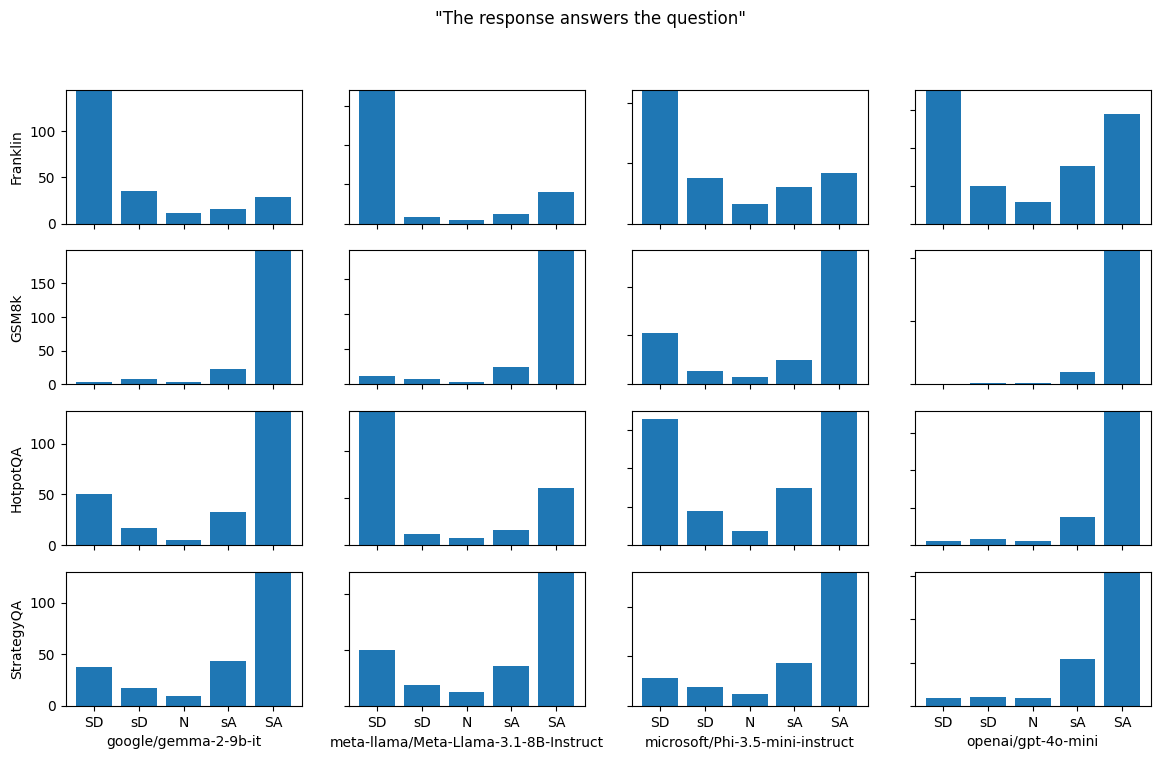

In [1072]:
point_scale = 5

# subplots in a 4x4 grid
fig, axs = plt.subplots(4, 4, figsize=(14, 8))

for d, dataset in enumerate(datasets):
    for m, model in enumerate(models):
        values = ask[(dataset, model)].to_numpy()
        # remove nan values from numpy array
        values = values[~pd.isna(values)]
        # frequency of each value
        counts = pd.Series(values).value_counts()
        # plot the frequency of each value
        axs[d, m].bar(counts.index, counts.values)
        # set x axis to i2t for each value
        axs[d, m].set_xticks(range(1, point_scale + 1))
        axs[d, m].set_xticklabels([i2t(i, point_scale) for i in range(1, point_scale + 1)], ha='center')
        # set y axis to 0-max frequency
        axs[d, m].set_ylim(0, counts.max())
        # set x axis label to the model
        axs[d, m].set_xlabel(model)
        # set y axis label to the dataset
        axs[d, m].set_ylabel(dataset)

# only show bottom x axis labels
for ax in axs.flat:
    ax.label_outer()

# set the title of the entire plot
fig.suptitle('"The response answers the question"')
plt.show()

In [1073]:
dataset = 'Franklin'
dataset = 'GSM8k'
dataset = 'HotpotQA'
dataset = 'StrategyQA'
model = 'google/gemma-2-9b-it'
model = 'meta-llama/Meta-Llama-3.1-8B-Instruct'
model = 'microsoft/Phi-3.5-mini-instruct'
model = 'openai/gpt-4o-mini'
# get questions['question'] with uuids from grouped_uuids[(dataset, model)]
questions = questions[(questions['dataset'] == dataset) & (questions['model'] == model)]

In [1074]:
questions

,uuid,is_attention_check,dataset,model,question,parsed_response,html
960,12c4c6a9-792e-4cd3-9330-c0b502e5c3e5,False,StrategyQA,openai/gpt-4o-mini,Does Princess Peach's dress resemble a peach f...,Princess Peach's dress does not directly resem...,<p><em>Does Princess Peach's dress resemble a ...
961,02b1fc1c-fbdc-4de4-b5cc-d64ed1c35caa,False,StrategyQA,openai/gpt-4o-mini,Would General Zod prefer an iPhone over a Sams...,While General Zod is a fictional character fro...,<p><em>Would General Zod prefer an iPhone over...
962,a97414d6-9b72-427c-b29d-c0818677ad9f,False,StrategyQA,openai/gpt-4o-mini,Would a honey badger fit inside an oven?,"Honey badgers are relatively small animals, ty...",<p><em>Would a honey badger fit inside an oven...
963,ee49d864-b307-4761-a271-ee6abbebe166,False,StrategyQA,openai/gpt-4o-mini,Could ten gallons of seawater crush a six year...,"Ten gallons of seawater, while heavy, would no...",<p><em>Could ten gallons of seawater crush a s...
964,b73426f3-fa0d-4d60-a4a5-46d24afd848e,False,StrategyQA,openai/gpt-4o-mini,Are there Pink music videos that are triggerin...,"Yes, some music videos by Pink, like those of ...",<p><em>Are there Pink music videos that are tr...
...,...,...,...,...,...,...,...
1019,6a0fc6a7-cbed-478d-a950-4b78738e1c12,False,StrategyQA,openai/gpt-4o-mini,Can Cyril Ramaphosa become Secretary General o...,"Cyril Ramaphosa, as the President of South Afr...",<p><em>Can Cyril Ramaphosa become Secretary Ge...
1020,f6ca623b-3b04-45b2-9909-51ac4a2ef449,False,StrategyQA,openai/gpt-4o-mini,Can a snake swallow an M60 Patton?,"No, a snake cannot swallow an M60 Patton tank....",<p><em>Can a snake swallow an M60 Patton?</em>...
1021,3efe2b88-9e40-4a1c-8587-ac7b524f9233,False,StrategyQA,openai/gpt-4o-mini,Would it be unusual to find a yellow perch in ...,"Yes, it would be unusual to find a yellow perc...",<p><em>Would it be unusual to find a yellow pe...
1022,9b038805-caa5-4e34-ba1c-83856376c705,False,StrategyQA,openai/gpt-4o-mini,Did Electronic Arts profit from Metroid sales?,"No, Electronic Arts (EA) did not profit from M...",<p><em>Did Electronic Arts profit from Metroid...
